In [53]:
# Dependencies! 

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [54]:
from scipy import stats
import numpy as np
import pandas as pd

In [55]:
import datetime as dt

In [56]:
# Reflect tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [57]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [58]:
# Reflect an existing database into a new model

Base = automap_base()

# Reflect tables

Base.prepare(engine, reflect=True)

In [59]:
Base.classes.keys()

['measurement', 'station']

In [60]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [61]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [62]:
# Precipitation Analysis

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


date_delta : 2016-08-23


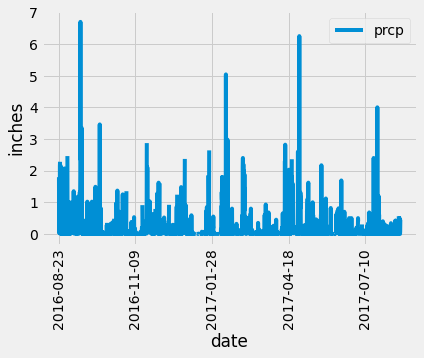

In [63]:
# Calculate the date 1 year ago from the last data point in the database

date_delta = dt.date(2017, 8, 23) - dt.timedelta(days = 365.25)
print("date_delta :", date_delta)

# Retrieve data and precipitation scores

data_precip = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= date_delta).all()
data_precip

# Save query results as a Pandas DataFrame and set the index to the date column

df_precip = pd.DataFrame(data_precip, columns=['date', 'prcp'])
df_precip.set_index('date', inplace=True)

# Sort dataframe by date

df_precip.sort_values(by=['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

df_precip.plot()
plt.xticks(rotation=90)
plt.ylabel('inches')
plt.savefig('date_del_precipitation.png')
plt.show()

In [64]:
# Calculate summary statistics for the precipitation data

df_precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [65]:
# Station Analysis
# How many stations are available in this dataset?

station_count = session.query(func.count(distinct(Measurement.station))).all()
station_unpacked = [x[0] for x in station_count]
print(f"There are {station_unpacked[0]} stations in the dataset")

There are 9 stations in the dataset


In [66]:
# What are the most active stations? (i.e. what stations have the most rows)? List in descending order

complete_obs = session.query(Measurement.station, func.count(Measurement.station)).\
filter(Measurement.tobs.isnot(None)).\
filter(Measurement.prcp.isnot(None)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
complete_obs

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [67]:
complete_obs_stations = [x[0] for x in complete_obs]
complete_obs_count = [x[1] for x in complete_obs]
print(f"{complete_obs_stations[0]} is the most active station with {complete_obs_count[0]} total observations")

USC00519281 is the most active station with 2772 total observations


In [68]:
# Calculate lowest temperature recorded, highest temperature recorded, and average temperature of the most active station
# Lowest Temp
most_active_lowest_temp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').first()
print(f"The lowest temperature observed for the most active station is {most_active_lowest_temp[0]}F")

# Highest Temp
most_active_highest_temp = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').first()
print(f"The highest temperature observed for the most active station is {most_active_highest_temp[0]}F")

# Average Temp
most_active_avg_temp = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').first()
print(f"The highest temperature observed for the most active station is {most_active_avg_temp[0]}F")

The lowest temperature observed for the most active station is 54.0F
The highest temperature observed for the most active station is 85.0F
The highest temperature observed for the most active station is 71.66378066378067F


Latest observation date for the most active station is on 2017-08-18
Query date for station with highest number of temperature observations : 2016-08-18


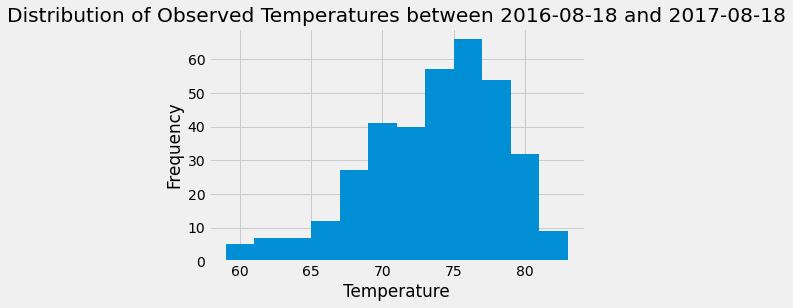

In [69]:

# With the highest # of temp observations, query the last 12 months of temperature observation data & plot the results as a histogram
# Latest date for which observation was made

most_active_latest_date =  session.query(func.max(Measurement.date)).\
filter(Measurement.station == 'USC00519281').first()
print(f"Latest observation date for the most active station is on {most_active_latest_date[0]}")

most_active_date_delta = dt.date(2017, 8, 18) - dt.timedelta(days = 365.25)
print("Query date for station with highest number of temperature observations :", most_active_date_delta)

most_active_date_delta_tobs = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= most_active_date_delta).all()

# Extract temperature observations

most_active_tobs = [x[1] for x in most_active_date_delta_tobs]
plt.hist(most_active_tobs, bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Observed Temperatures between 2016-08-18 and 2017-08-18')
plt.savefig('tobs_hist.png')
plt.show()

In [84]:
# Bonus: Temp Analysis

# Temperature in June across all years

june_temp = session.query(Measurement.date, func.avg(Measurement.tobs)).\
filter(func.strftime("%m", Measurement.date) == "06").\
group_by(Measurement.station).all()
june_temp_avg = [x[1] for x in june_temp]

# Temperature in December across all years

dec_temp = session.query(Measurement.date, func.avg(Measurement.tobs)).\
filter(func.strftime("%m", Measurement.date) == "12").\
group_by(Measurement.station).all()
dec_temp_avg = [x[1] for x in dec_temp]

print("Result of unpaired t-test :", stats.ttest_ind(june_temp_avg, dec_temp_avg ))
print("pvalue < 0.05 indicates the difference of the means is statistically significant.")

Result of unpaired t-test : Ttest_indResult(statistic=4.615865424404701, pvalue=0.00028626292761018595)
pvalue < 0.05 indicates the difference of the means is statistically significant.


In [72]:
# Temp Analysis 2
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Dates for 15 days holiday

trip_end_delta = dt.date(2016, 7, 3) - dt.timedelta(days = 365.25)
trip_start_delta = dt.date(2016, 7, 3) - dt.timedelta(days = 380.25)
print("Trip Start date :", trip_start_delta)
print("Trip End date :", trip_end_delta)

# T-min, T-avg and T-max for the two weeks trip

trip_stats = calc_temps('2015-06-19', '2015-07-04')
trip_stats_tmin = [x[0] for x in trip_stats]
trip_stats_tavg = [x[1] for x in trip_stats]
trip_stats_tmax = [x[2] for x in trip_stats]
tmin = trip_stats_tmin[0]
tavg = trip_stats_tavg[0]
tmax = trip_stats_tmax[0]
print("TMIN :", tmin)
print("TAVG :", tavg)
print("TMAX :", tmax)

Trip Start date : 2015-06-19
Trip End date : 2015-07-04
TMIN : 67.0
TAVG : 75.8
TMAX : 82.0


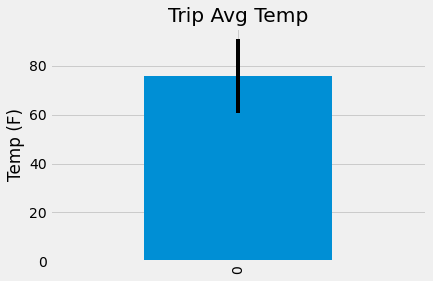

In [73]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_stats_df = pd.DataFrame(trip_stats, columns=['min_t', 'avg_t', 'max_t'])
trip_stats_df
error = tmax-tmin
trip_stats_df['avg_t'].plot(kind = 'bar', yerr=error)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.savefig('trip_bar_chart.png')
plt.show()

In [71]:
# Total Amt of Rainfall / weather station for trip dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Query for total precipitation for trip duration
prcp_total = session.query(Measurement.station, func.sum(Measurement.prcp)).\
filter(Measurement.prcp.isnot(None)).\
filter(Measurement.date >= '2015-06-19').\
filter(Measurement.date <= '2015-07-04').\
group_by(Measurement.station).all()

# Load query into dataframe
prcp_trip_total = pd.DataFrame(prcp_total, columns=['station', 'prcp_amount'])

# Query Station table and load into dataframe
station_table = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_table_df = pd.DataFrame(station_table, columns=['station','name', 'latitude', 'longitude', 'elevation'])

prcp_merged = pd.merge(prcp_trip_total, station_table_df, on='station')
prcp_merged

,station,prcp_amount,name,latitude,longitude,elevation
0,USC00511918,0.02,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
1,USC00513117,0.61,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,1.76,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00516128,5.91,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00517948,0.13,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00519281,1.80,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,USC00519397,0.14,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,USC00519523,0.19,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [75]:
# Daily rainfall average

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [113]:
# Calculate daily norms for trip

start_date = trip_start_delta
end_date = trip_end_delta

date_generated = [start_date + dt.timedelta(days=x) for x in range(0, (end_date-start_date).days)]

dates_stripped = []
for date in date_generated:
    dates_stripped.append(date.strftime("%m-%d"))
print(dates_stripped)

normals = []
for mnth_day in dates_stripped:
        
    normals.append(daily_normals(mnth_day))
print(normals)

['06-19', '06-20', '06-21', '06-22', '06-23', '06-24', '06-25', '06-26', '06-27', '06-28', '06-29', '06-30', '07-01', '07-02', '07-03']
[[(70.0, 75.44067796610169, 82.0)], [(68.0, 73.96491228070175, 85.0)], [(68.0, 74.75862068965517, 82.0)], [(69.0, 75.15789473684211, 81.0)], [(68.0, 74.54385964912281, 80.0)], [(68.0, 74.96428571428571, 84.0)], [(68.0, 74.10344827586206, 80.0)], [(67.0, 74.21428571428571, 82.0)], [(66.0, 75.01785714285714, 81.0)], [(69.0, 74.88679245283019, 80.0)], [(67.0, 74.91525423728814, 80.0)], [(67.0, 75.59615384615384, 81.0)], [(67.0, 74.77777777777777, 81.0)], [(68.0, 75.40384615384616, 82.0)], [(68.0, 75.32075471698113, 87.0)]]


In [126]:
# Load previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame([t for lst in normals for t in lst], columns=['tmin', 'tavg', 'tmax'])
normals_df

,tmin,tavg,tmax
0,70.0,75.440678,82.0
1,68.0,73.964912,85.0
2,68.0,74.758621,82.0
3,69.0,75.157895,81.0
4,68.0,74.543860,80.0
5,68.0,74.964286,84.0
6,68.0,74.103448,80.0
7,67.0,74.214286,82.0
8,66.0,75.017857,81.0
9,69.0,74.886792,80.0


In [130]:
normals_df['trip_dates'] = [x.strftime("%Y-%m-%d") for x in date_generated]
normals_df.set_index('trip_dates', inplace=True)
normals_df

,tmin,tavg,tmax
trip_dates,,,
2015-06-19,70.0,75.440678,82.0
2015-06-20,68.0,73.964912,85.0
2015-06-21,68.0,74.758621,82.0
2015-06-22,69.0,75.157895,81.0
2015-06-23,68.0,74.543860,80.0
2015-06-24,68.0,74.964286,84.0
2015-06-25,68.0,74.103448,80.0
2015-06-26,67.0,74.214286,82.0
2015-06-27,66.0,75.017857,81.0


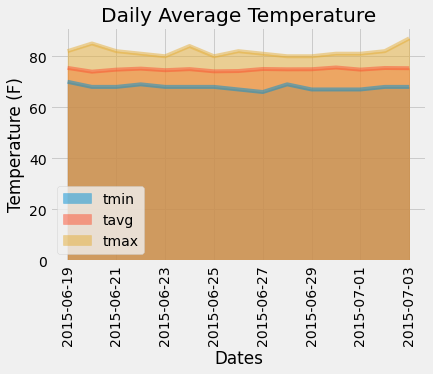

In [135]:
ax = normals_df.plot.area(stacked=False)
plt.xticks(rotation=90)
plt.xlabel('Dates')
plt.ylabel('Temperature (F)')
plt.title('Daily Average Temperature')
plt.savefig('daily_rainfall.png')
plt.show()